In [1]:
# we can use multiple data sources for this
# Flukebook
from __future__ import division, print_function
from os.path import join
import cPickle as pickle


with open('../dataset_loc', 'r') as f:
    dataset_loc = f.read().rstrip()
    
with open(join(dataset_loc, 'Flukes/Flukebook/flukebook_points_orig.pkl'), 'r') as f:
    fb_points = pickle.load(f)
print(len(fb_points))

2178


In [2]:
# Zooniverse
with open(join(dataset_loc, 'ibs_points_allindv.pkl'), 'r') as f:
    zsl_points = pickle.load(f)
    
print(len(zsl_points))

1970


In [3]:
# Our own annotations
from glob import glob
import json
annotation_path = "/home/andrew/envs/whaleFlukes/whale_edge_annotations/annotation_info"

all_annotations = glob(join(annotation_path, '*'))
annotation_points = []
for annotation_fn in all_annotations:
    with open(annotation_fn, 'r') as f:
        annotation = json.load(f)
        if annotation[1]['done'] and not annotation[1]['bad'] and not annotation[1]['notchSubmerged']:
            this_annot = {'fn':annotation[0]}
            this_annot['left'] = annotation[1]['topInfo']['path'][-1]
            this_annot['right'] = annotation[1]['topInfo']['path'][0]
            this_annot['notch'] = annotation[1]['notch']
            annotation_points.append(this_annot)
print(len(annotation_points))

489


In [4]:
fb_imgs_dir = join(dataset_loc, "Flukes/Flukebook/images")
zsl_and_annot_imgs_dir  = join(dataset_loc, "Flukes/CRC_combined constrained")

(963, 1564)


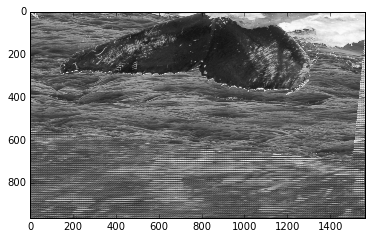

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# let's make an image augmenter
# rotations: flips make sense, but rotations beyond 20 deg (arbitrary) don't
# scale: doesn't make sense to change since it'll be locked down to 64x64 anyways
# blur: gaussian w/std up to a certain amount

def test_aug(transform_matrix, size, image):
    image = cv2.blur(image, (size,size))
    image = cv2.warpAffine(image, transform_matrix, image.shape[::-1], borderMode=cv2.BORDER_TRANSPARENT, 
                                                                       borderValue=255)
    return image

testimg = cv2.cvtColor(cv2.imread(join(fb_imgs_dir, fb_points[0]['fn'])),cv2.COLOR_BGR2GRAY)
testaug = np.matrix("-1 -0.1; 0.1 -1; 1500 700",dtype=np.float32).T
testsize = 1
plt.gray()
aug_img = test_aug(testaug, testsize, testimg)
print(aug_img.shape)
plt.imshow(aug_img)

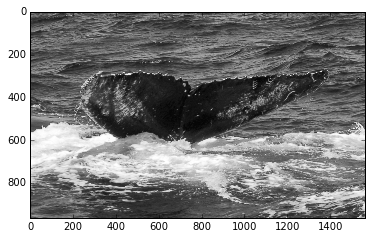

In [16]:
plt.imshow(testimg)

In [5]:


#fixed_shape = (224, 224) # so I can transfer over Imagenet trained models
fixed_shape = (64, 64) # so I can minimize size of network


def resize_point(new_shape, old_shape, point):
    # check that the point is inside the bounds of the image
    if ((point[0] < 0) or (point[0] > old_shape[1])) or ((point[1] < 0) or (point[1] > old_shape[0])):
        print("Point %s is out of bounds for shape %s" % (point, old_shape))
        raise IndexError("Point is out of bounds")
    # assume point is x, y
    scale_x = new_shape[1] / old_shape[1]
    scale_y = new_shape[0] / old_shape[0]
    
    new_pt = np.array([int(point[0]*scale_x), int(point[1]*scale_y)]).reshape(1,-1)
    return new_pt

def convert_img_points(new_size, img, left, right, notch):
    # assume new_size is y, x (makes sense for everything except cv2)
    resized_img = cv2.resize(img, new_size[::-1])

    resized_left = resize_point(new_size, img.shape, left)
    resized_right = resize_point(new_size, img.shape, right)
    resized_notch = resize_point(new_size, img.shape, notch)
    
    return resized_img, np.vstack([resized_left, resized_right, resized_notch])
    
xyc = lambda pt: (pt['x'], pt['y'])
    
# these need to stay parallel
fb_kp_imgs = []
fb_kp_pts = []
fb_kp_sizes = []
for annot in fb_points:
    img = cv2.imread(join(fb_imgs_dir, annot['fn']))
    try:
        resized_img, res_points = convert_img_points(fixed_shape, img, 
                                         xyc(annot['points']['left']), xyc(annot['points']['right']), 
                                                                         xyc(annot['points']['notch']))
    except IndexError as ie:
        print("Bad points on image %s" % annot['fn'])
        continue
    fb_kp_imgs.append(resized_img)
    fb_kp_pts.append(res_points)
    fb_kp_sizes.append((img.shape,join(fb_imgs_dir, annot['fn'])))
# guide: so each of <src>_kp_pts is going to be a matrix where each row is the x, y coords of each point in 
# left, right, notch respectively

Point (1660, 34) is out of bounds for shape (600, 800, 3)
Bad points on image extract1acbcbd6-4e31-4e58-923c-de40b579b11f.jpg
Point (1675, 70) is out of bounds for shape (600, 800, 3)
Bad points on image extract1d213e9e-27ba-4de5-849f-1c694fb4ca56.jpg
Point (2217, 130) is out of bounds for shape (600, 800, 3)
Bad points on image extract1e870b27-5edb-4179-9f93-42750f851f11.jpg
Point (2168, 27) is out of bounds for shape (600, 800, 3)
Bad points on image extract222ca4aa-1785-435b-834c-1301ac744d6a.jpg
Point (1971, 134) is out of bounds for shape (600, 800, 3)
Bad points on image extract24e6f12b-1510-440f-8058-139d1f4a1074.jpg
Point (2243, 33) is out of bounds for shape (600, 800, 3)
Bad points on image extract260871e1-2126-4274-b740-1087ef54ab1d.jpg
Point (1725, 15) is out of bounds for shape (600, 800, 3)
Bad points on image extract277df90a-dff2-409b-b78a-a6c27c3a3a50.jpg
Point (1876, 28) is out of bounds for shape (600, 800, 3)
Bad points on image extract3242b464-273b-42f9-abb3-69d5141

KeyboardInterrupt: 

In [ ]:
zsl_kp_imgs = []
zsl_kp_pts = []
zsl_kp_sizes = []

seen_imgs = set()

zsl_points.keys()

for imgn in zsl_points:
    img = cv2.imread(join(zsl_and_annot_imgs_dir, imgn))
    resized_img, res_points = convert_img_points(fixed_shape, img,
                                        zsl_points[imgn]['left'], zsl_points[imgn]['right'], 
                                                                     zsl_points[imgn]['notch'])
    seen_imgs.add(imgn)
    zsl_kp_imgs.append(resized_img)
    zsl_kp_pts.append(res_points)
    zsl_kp_sizes.append((img.shape, join(zsl_and_annot_imgs_dir, imgn)))

In [ ]:
annot_kp_imgs = []
annot_kp_pts = []
annot_kp_sizes = []

for annot in annotation_points:
    if annot['fn'] in seen_imgs:
        print("Already saw %s in the ZSL data, skipping" % annot['fn'])
        continue
    img = cv2.imread(join(zsl_and_annot_imgs_dir, imgn))
    resized_img, res_points = convert_img_points(fixed_shape, img,
                                        annot['left'], annot['right'], annot['notch'])
    annot_kp_imgs.append(resized_img)
    annot_kp_pts.append(res_points)
    annot_kp_sizes.append((img.shape,join(zsl_and_annot_imgs_dir, imgn)))

In [ ]:
len(annot_kp_imgs)

In [ ]:
from itertools import chain
all_kp_imgs = np.stack([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
               for img in list(chain(fb_kp_imgs, zsl_kp_imgs, annot_kp_imgs))], axis=0)
all_kp_pts = np.stack(list(chain(fb_kp_pts, zsl_kp_pts, annot_kp_pts)), axis=0)
all_kp_sizes = np.stack(list(chain(fb_kp_sizes, zsl_kp_sizes, annot_kp_sizes)), axis=0)

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

kp_imgs, kp_pts, kp_sizes = shuffle(all_kp_imgs, all_kp_pts, all_kp_sizes)
train_kp_imgs, test_kp_imgs, train_kp_pts, test_kp_pts, train_kp_sizes, test_kp_sizes = train_test_split(kp_imgs, kp_pts, kp_sizes)
train_kp_imgs, val_kp_imgs, train_kp_pts, val_kp_pts, train_kp_sizes, val_kp_sizes = train_test_split(train_kp_imgs, train_kp_pts, train_kp_sizes)

print(train_kp_imgs.shape)
print(train_kp_pts.shape)
print(train_kp_sizes.shape)

In [ ]:
train_kp_sizes[0]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def display_kpgt(img, points):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(color_img, (points[0,0], points[0,1]), 2, (255,0,0), -1) # left
    cv2.circle(color_img, (points[1,0], points[1,1]), 2, (0,255,0), -1) # right
    cv2.circle(color_img, (points[2,0], points[2,1]), 2, (0,0,255), -1) # notch
    plt.figure(figsize=(10,10))
    plt.imshow(color_img)

    
import random
ind = random.choice(range(len(train_kp_imgs)))
display_kpgt(train_kp_imgs[ind], train_kp_pts[ind])

In [ ]:
from train_utils import save_dataset

In [ ]:
dset_name = 'all_kpts_64_sizes'
save_dataset(join(dataset_loc,'Flukes/kpts/%s' % dset_name),
             (train_kp_imgs, train_kp_pts, train_kp_sizes), 
             (val_kp_imgs, val_kp_pts, val_kp_sizes), 
             (test_kp_imgs, test_kp_pts, test_kp_sizes))
